In [1]:
from datetime import datetime, timedelta
from pathlib import Path

import janitor
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as gg
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize": (10, 6)})

In [123]:
data_dir = Path("..", "data", "dataframes")
nws_df_path = data_dir / "national-weather-service.pkl"
cc_df_path = data_dir / "climacell.pkl"
owm_df_path = data_dir / "open-weather-map.pkl"

START_DATE = "2021-03-28 12:00:00"

In [113]:
nws_df = pd.read_pickle(nws_df_path).clean_names()
nws_df = nws_df[nws_df["starttime"] >= START_DATE]
nws_df.head()

,detailedforecast,shortforecast,starttime,endtime,icon,isdaytime,name,number,temperature,temperatureunit,temperaturetrend,winddirection,windspeed,collection_timestamp,city,forecast_type
0,"Sunny, with a high near 52. West wind 18 to 23...",Sunny,2021-03-29 14:00:00-04:00,2021-03-29 18:00:00-04:00,https://api.weather.gov/icons/land/day/wind_sk...,True,This Afternoon,1,52.0,F,None,W,18 to 23 mph,2021-03-29 18:23:29.503596,tuscon,daily
1,"Clear, with a low around 28. West wind 5 to 15...",Clear,2021-03-29 18:00:00-04:00,2021-03-30 06:00:00-04:00,https://api.weather.gov/icons/land/night/skc?s...,False,Tonight,2,28.0,F,None,W,5 to 15 mph,2021-03-29 18:23:29.503596,tuscon,daily
2,"Sunny, with a high near 54. Southwest wind 3 t...",Sunny,2021-03-30 06:00:00-04:00,2021-03-30 18:00:00-04:00,https://api.weather.gov/icons/land/day/skc?siz...,True,Tuesday,3,54.0,F,None,SW,3 to 15 mph,2021-03-29 18:23:29.503596,tuscon,daily
3,"Partly cloudy, with a low around 44. South win...",Partly Cloudy,2021-03-30 18:00:00-04:00,2021-03-31 06:00:00-04:00,https://api.weather.gov/icons/land/night/sct?s...,False,Tuesday Night,4,44.0,F,None,S,10 to 14 mph,2021-03-29 18:23:29.503596,tuscon,daily
4,"Partly sunny, with a high near 63. South wind ...",Partly Sunny,2021-03-31 06:00:00-04:00,2021-03-31 18:00:00-04:00,https://api.weather.gov/icons/land/day/bkn?siz...,True,Wednesday,5,63.0,F,None,S,10 to 16 mph,2021-03-29 18:23:29.503596,tuscon,daily


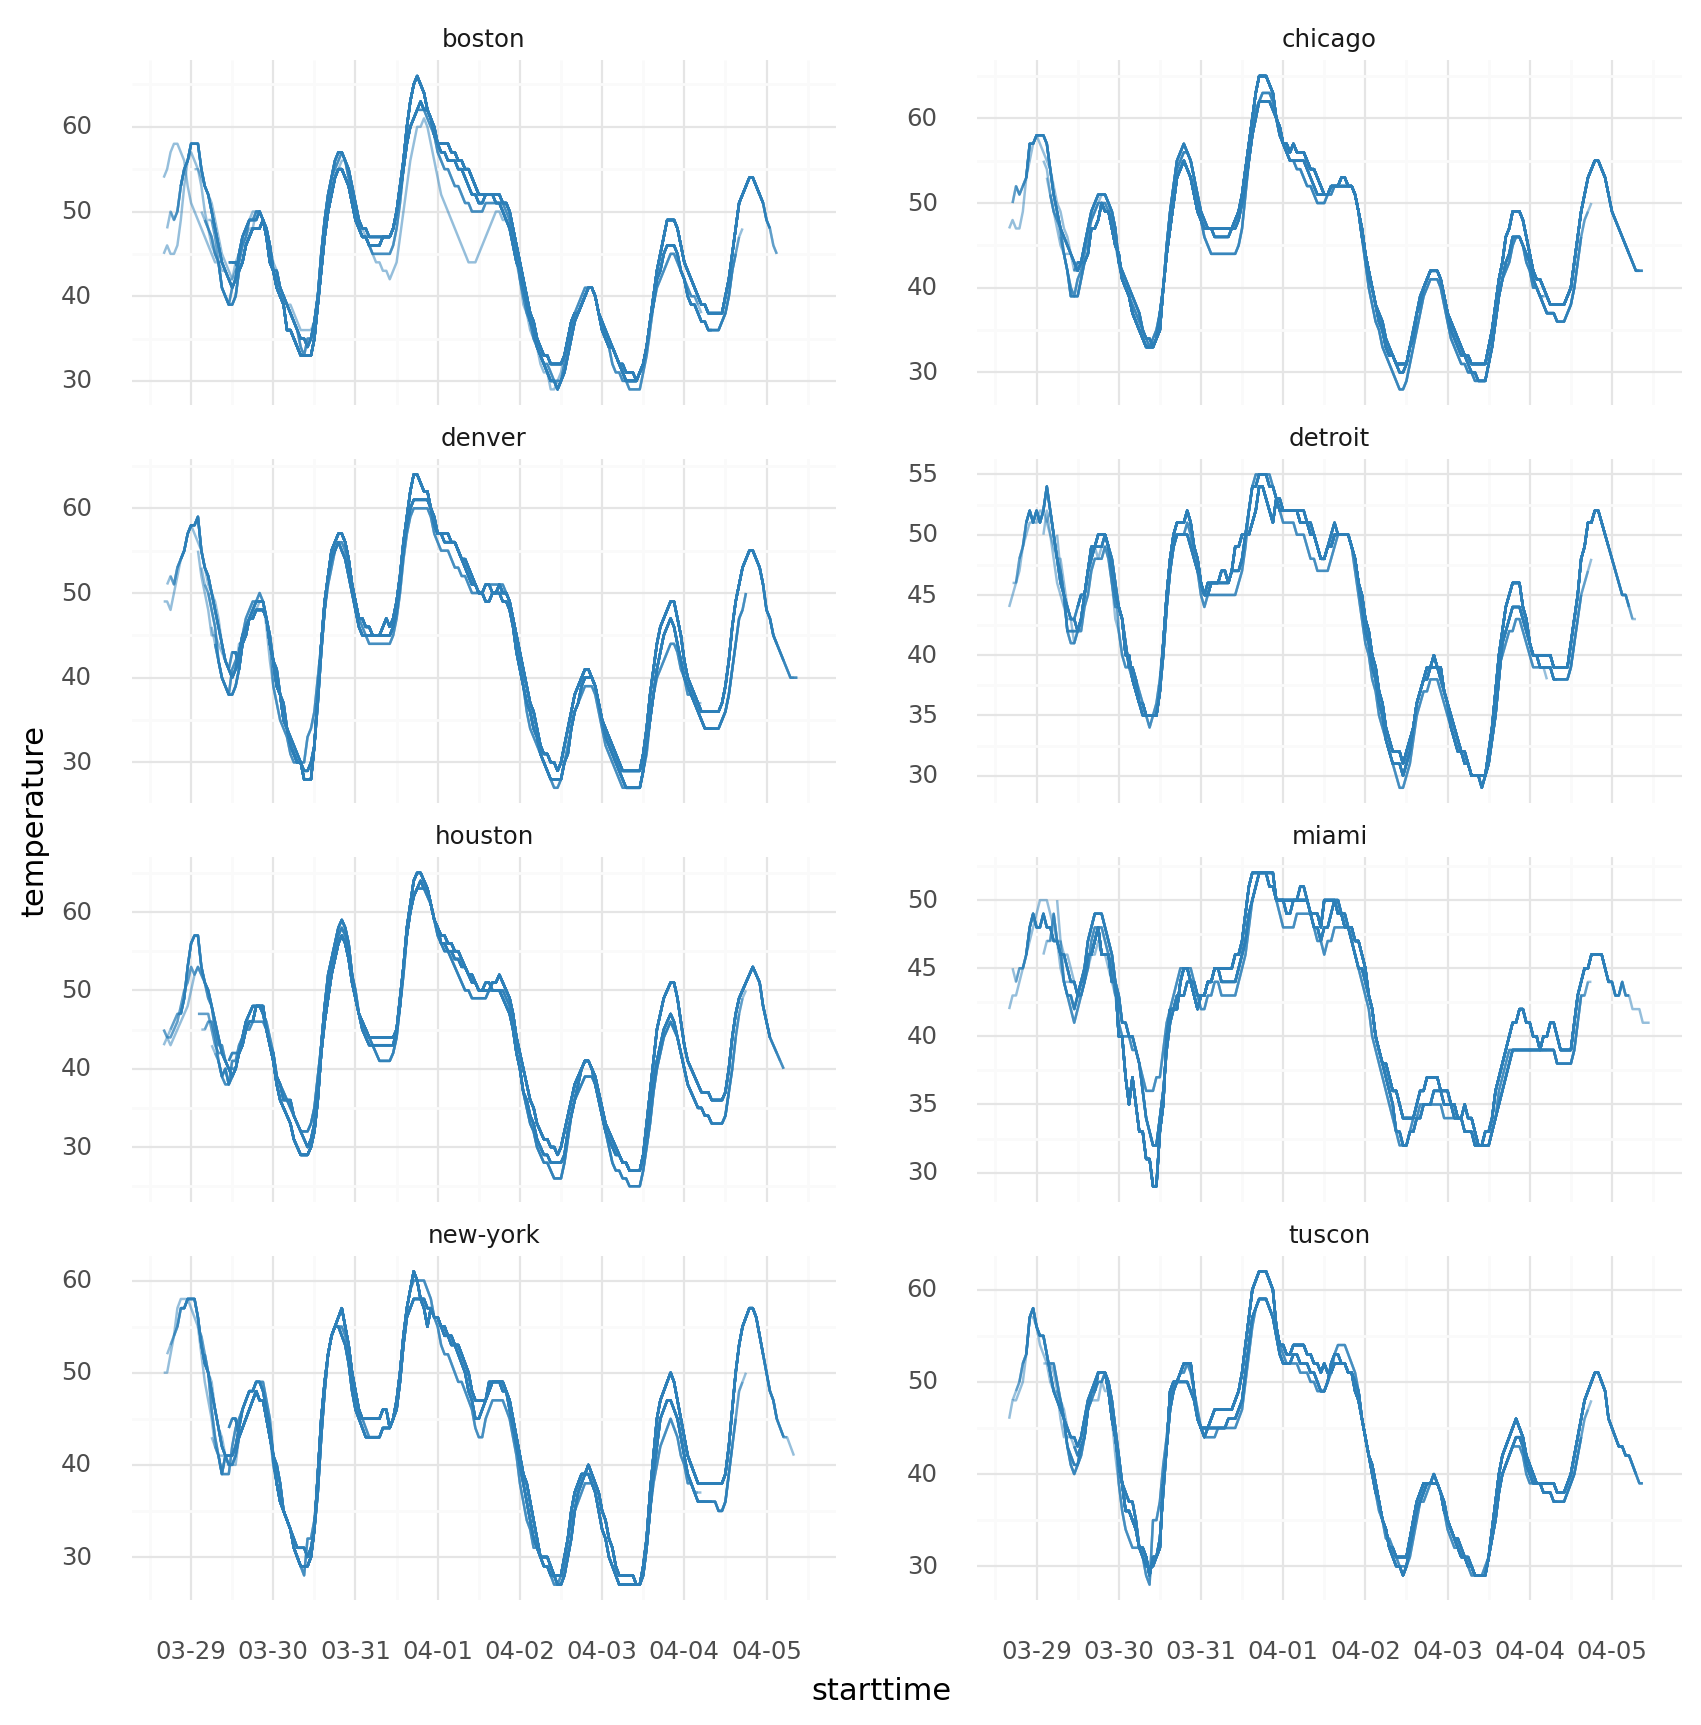

<ggplot: (331310141)>

In [114]:
nws_hourly = nws_df.copy()[nws_df["forecast_type"] == "hourly"]

(
    gg.ggplot(nws_hourly, gg.aes(x="starttime", y="temperature"))
    + gg.facet_wrap("~ city", ncol=2, scales="free_y")
    + gg.geom_line(
        gg.aes(group="factor(collection_timestamp)"), alpha=0.5, color="#2c7fb8"
    )
    + gg.scale_x_datetime(date_labels="%m-%d")
    + gg.theme_minimal()
    + gg.theme(figure_size=(10, 10), subplots_adjust={"wspace": 0.2})
)

## ClimaCell

In [115]:
cc_df = pd.read_pickle(cc_df_path).clean_names()
cc_df = cc_df[cc_df.collection_timestamp >= START_DATE]
cc_df.head()

,temperature,temperatureapparent,precipitationintensity,precipitationprobability,precipitationtype,visibility,cloudcover,weathercode,humidity,windspeed,starttime,forecast_type,collection_timestamp,city
0,1.33,-3.07,0.0,0.0,1.0,11.44,25.31,1100,62.56,4.81,2021-03-29 05:22:00+00:00,current,2021-03-29 05:22:08.575221,detroit
1,1.33,-3.07,0.0,0.0,1.0,11.44,25.31,1100,62.56,4.81,2021-03-29 05:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit
2,-0.45,-4.55,0.0,0.0,1.0,16.00,0.00,1000,69.22,3.60,2021-03-29 06:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit
3,-0.66,-4.58,0.0,0.0,1.0,16.00,0.00,1000,71.37,3.34,2021-03-29 07:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit
4,-0.83,-4.25,0.0,0.0,1.0,16.00,0.00,1000,74.18,2.75,2021-03-29 08:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit


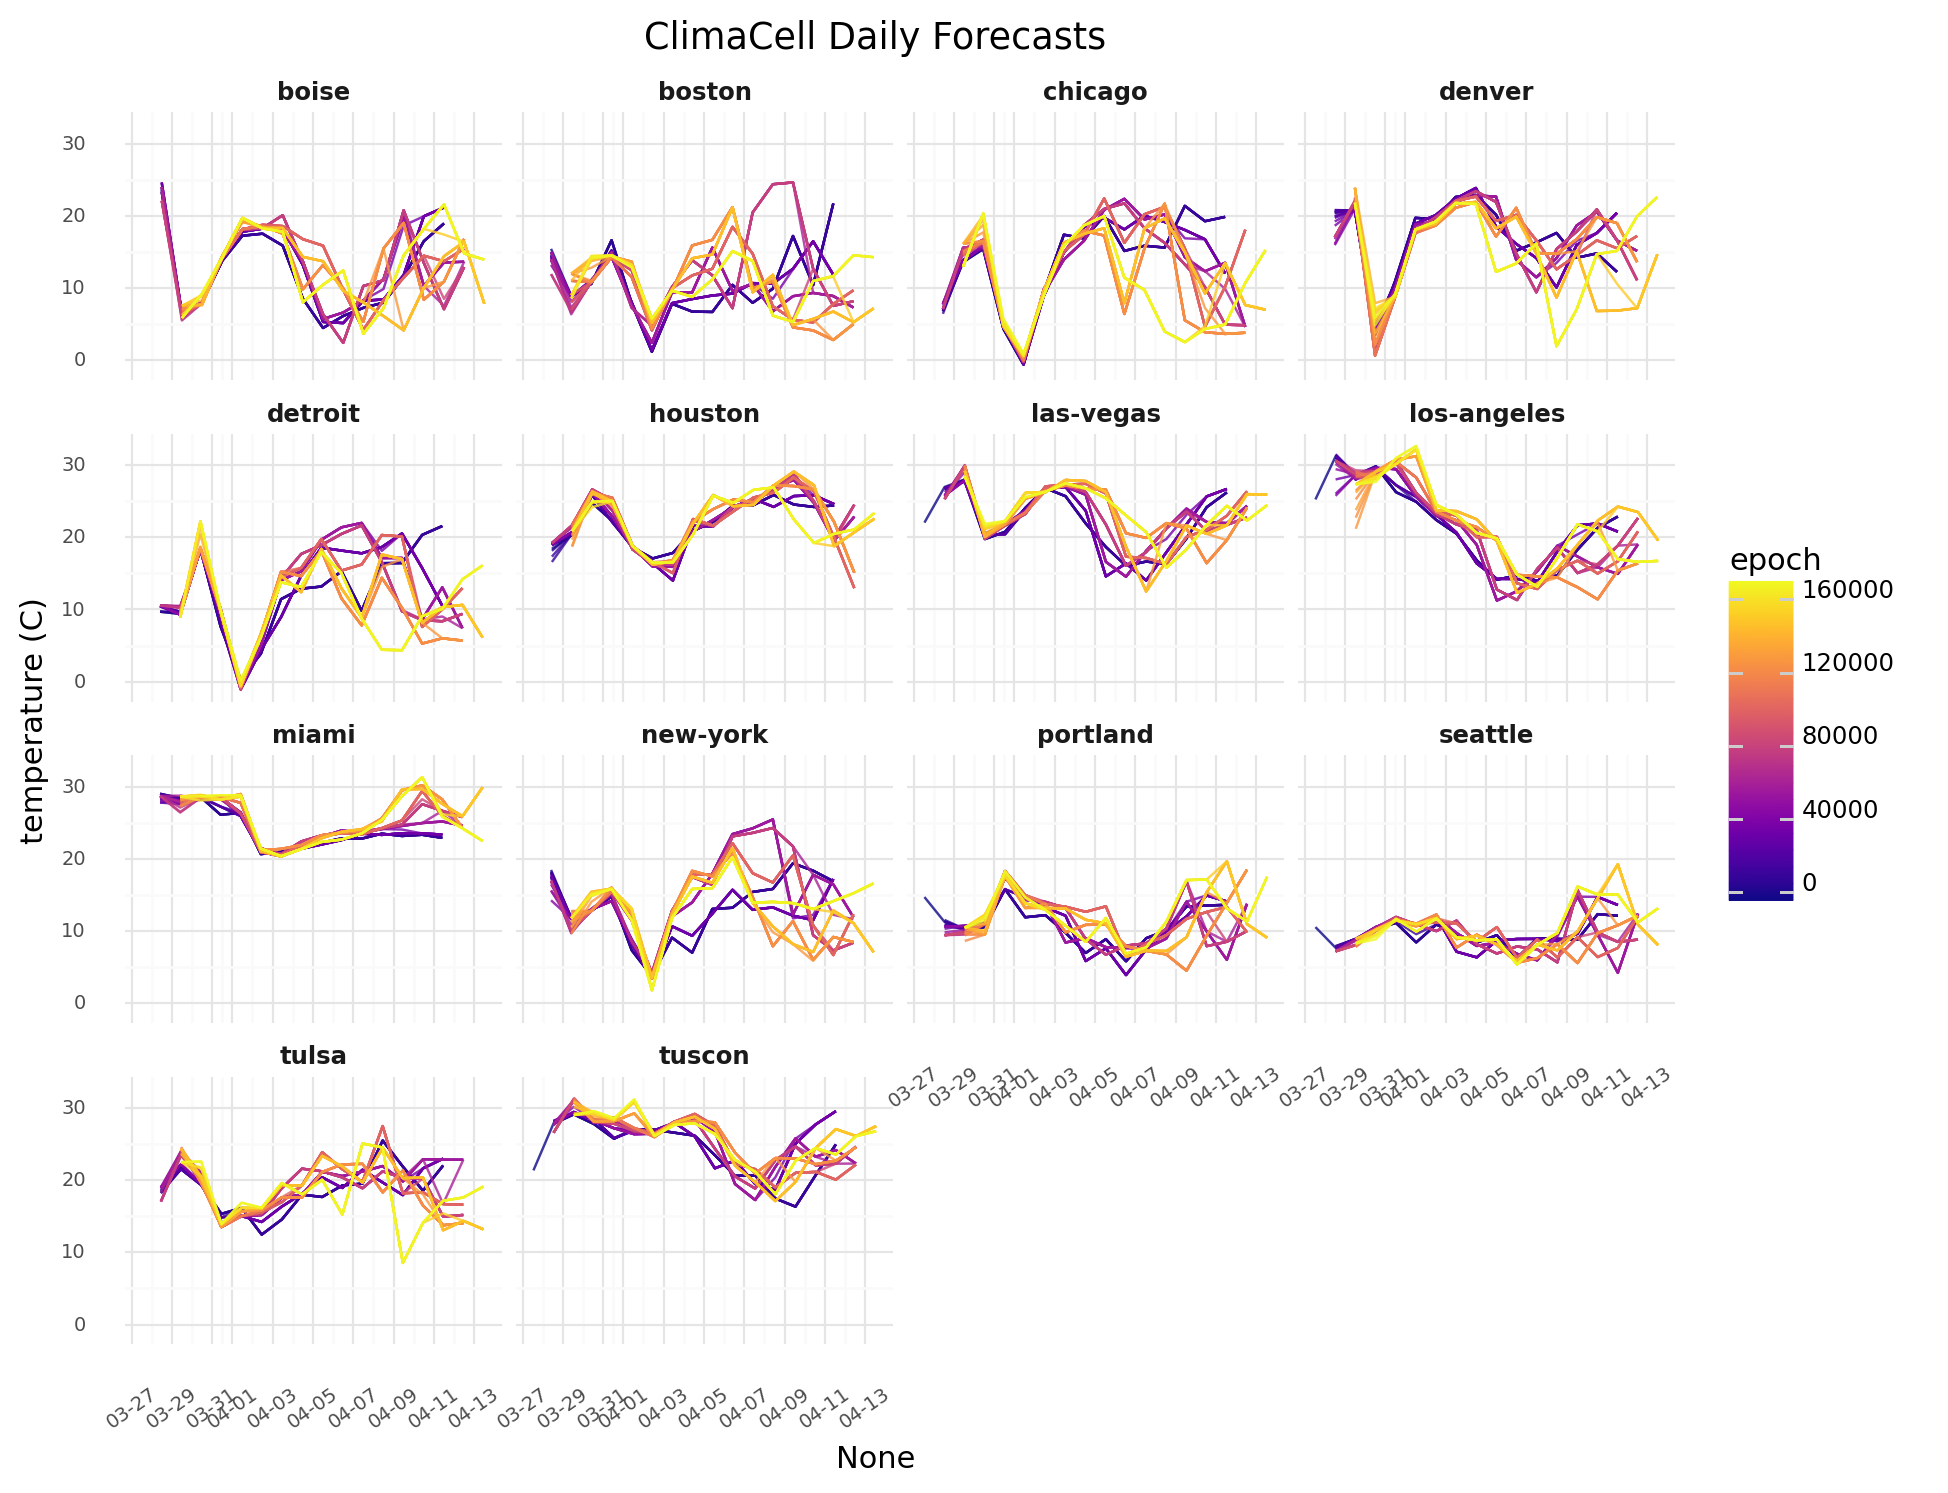

<ggplot: (333324002)>

In [121]:
cc_daily = cc_df.copy()[cc_df.forecast_type == "daily"]
cc_daily["epoch"] = (
    cc_daily["collection_timestamp"] - min(cc_daily["collection_timestamp"])
).dt.total_seconds()

(
    gg.ggplot(cc_daily, gg.aes(x="starttime", y="temperature"))
    + gg.facet_wrap("~ city", ncol=4)
    + gg.geom_line(gg.aes(color="epoch", group="factor(epoch)"), alpha=0.8)
    + gg.scale_x_datetime(date_labels="%m-%d")
    + gg.scale_color_continuous("plasma")
    + gg.theme_minimal()
    + gg.theme(
        figure_size=(10, 8),
        axis_text_x=gg.element_text(angle=35, size=7),
        axis_text_y=gg.element_text(size=7),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
    )
    + gg.labs(x="None", y="temperature (C)", title="ClimaCell Daily Forecasts")
)

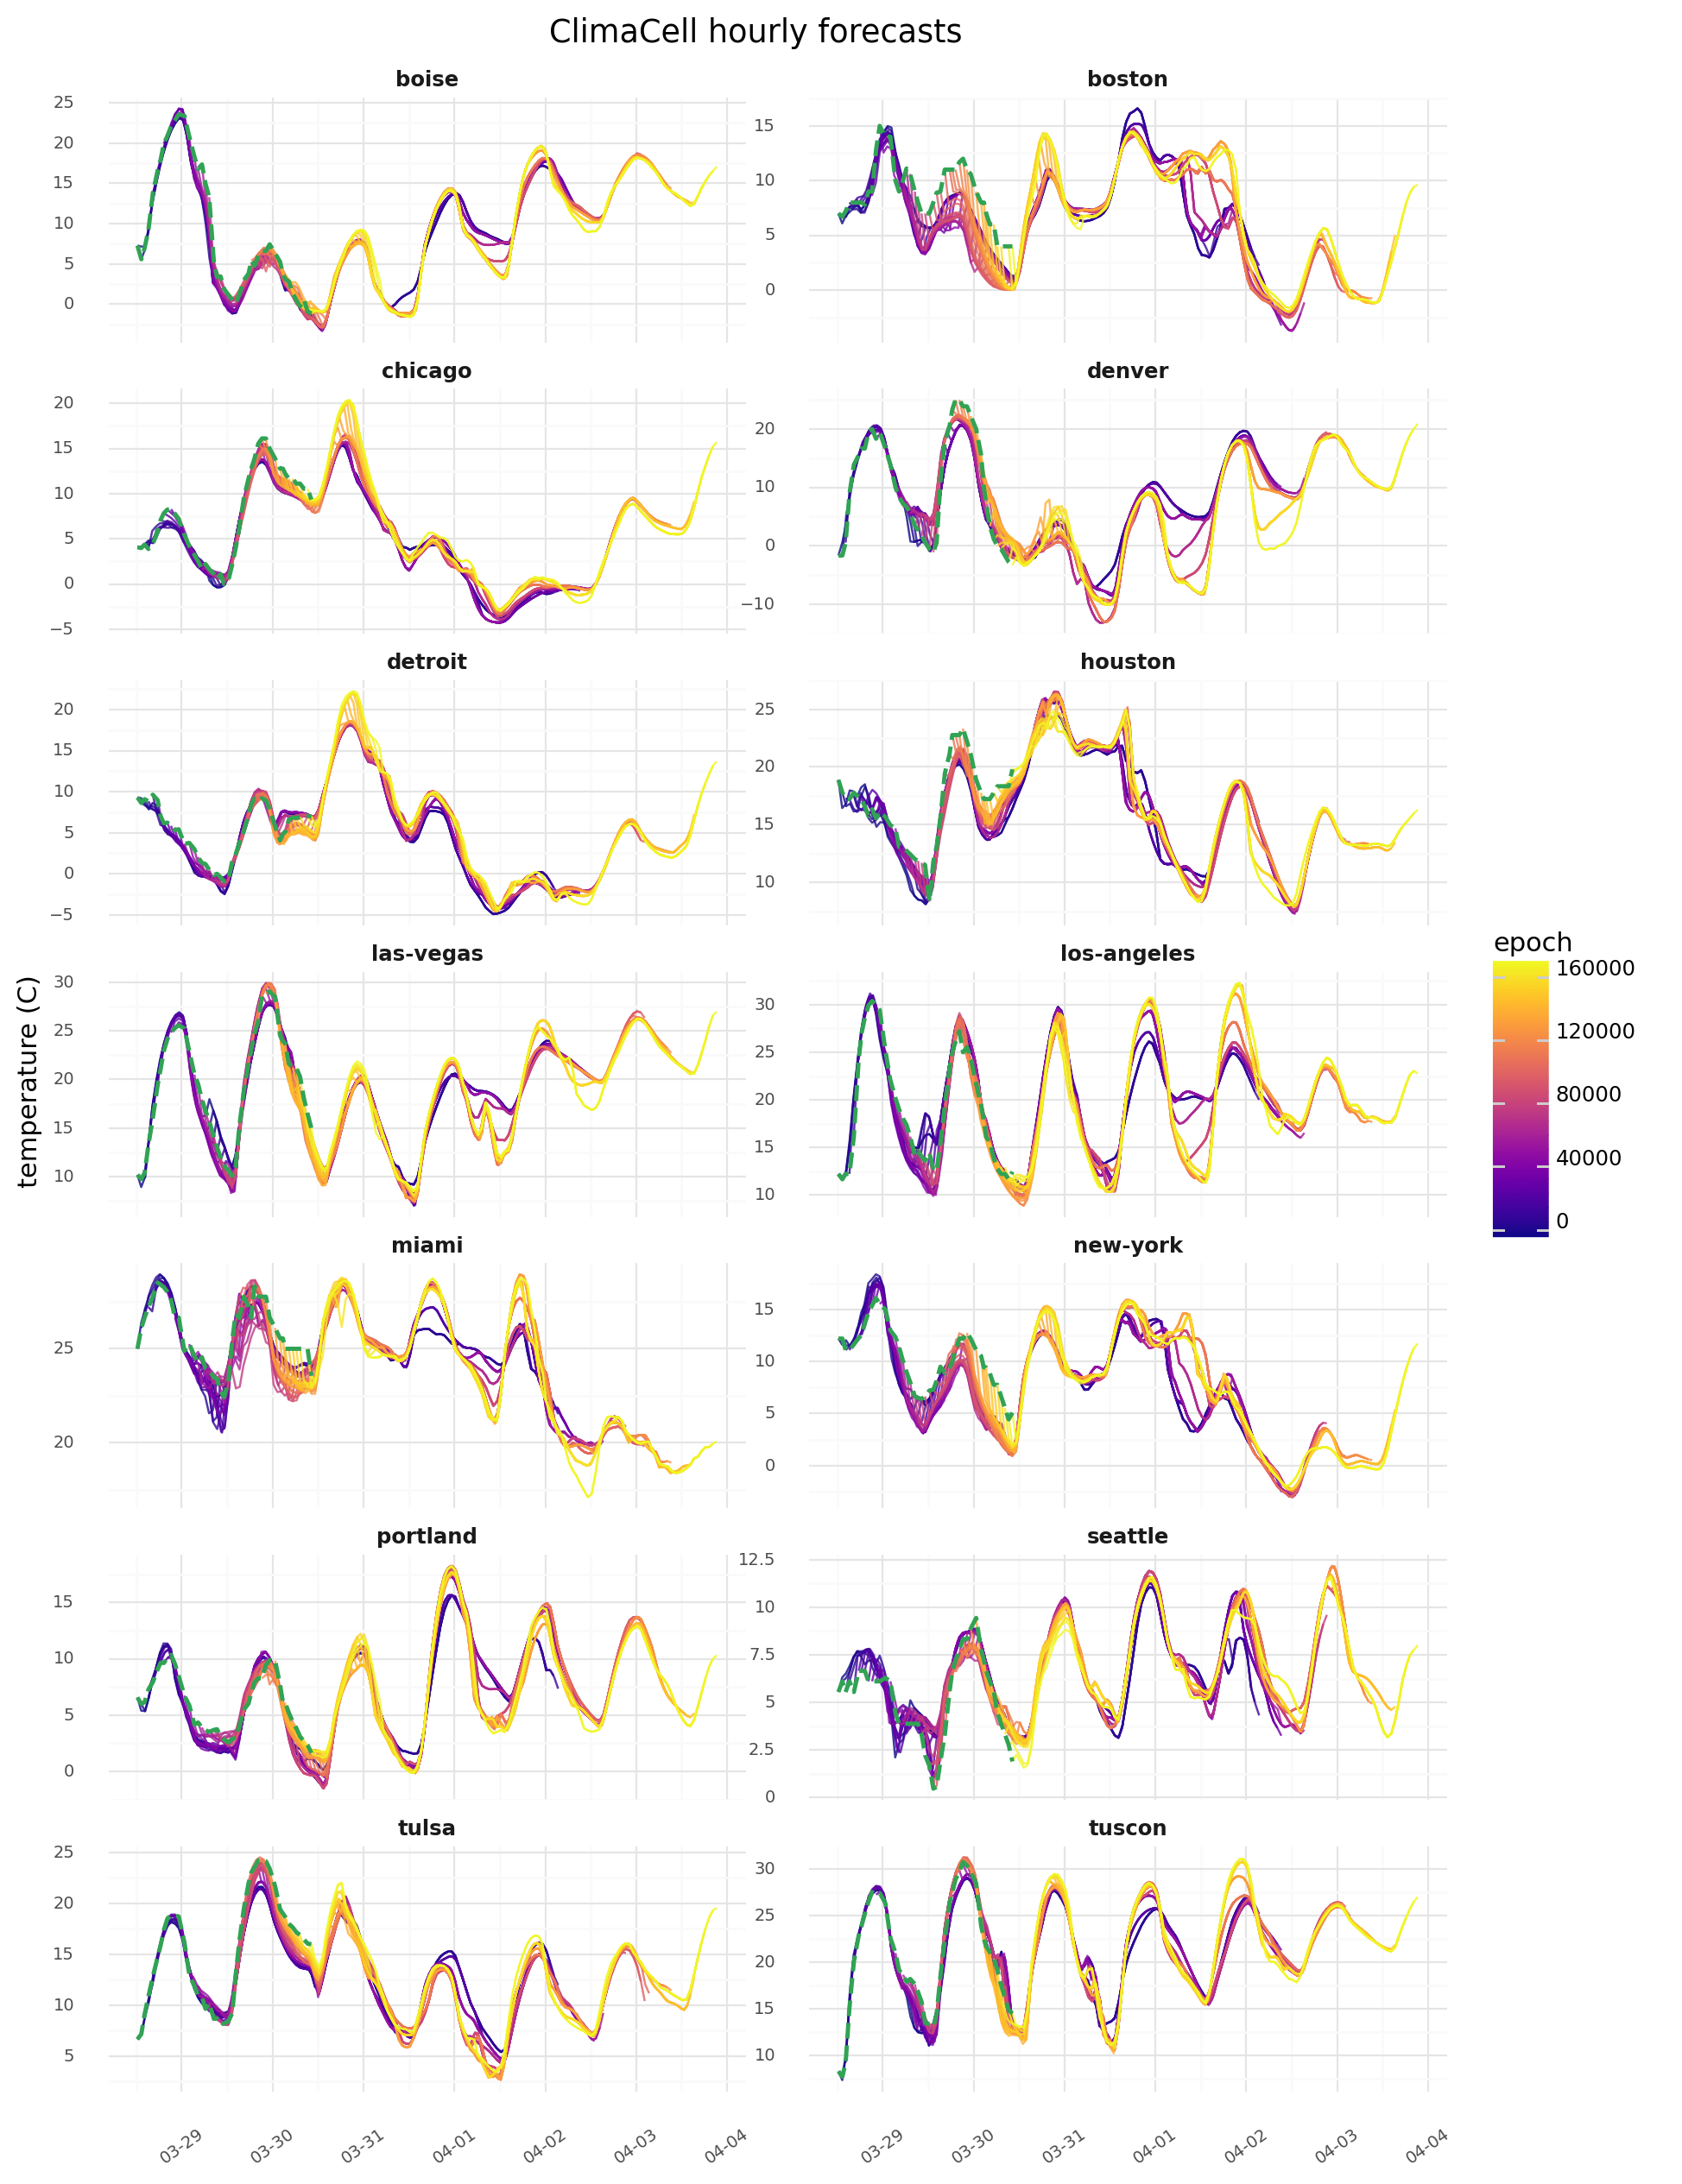

<ggplot: (336099247)>

In [122]:
cc_hourly = cc_df.copy()[cc_df.forecast_type == "hourly"]
cc_hourly["epoch"] = (
    cc_hourly["collection_timestamp"] - min(cc_hourly["collection_timestamp"])
).dt.total_seconds()

cc_current = cc_df.copy()[cc_df.forecast_type == "current"]
cc_current["epoch"] = (
    cc_current["collection_timestamp"] - min(cc_hourly["collection_timestamp"])
).dt.total_seconds()

(
    gg.ggplot(cc_hourly, gg.aes(x="starttime", y="temperature"))
    + gg.facet_wrap("~ city", ncol=2, scales="free_y")
    + gg.geom_line(gg.aes(color="epoch", group="factor(epoch)"), alpha=0.8)
    + gg.geom_line(data=cc_current, color="#31a354", size=1, alpha=1, linetype="--")
    + gg.scale_x_datetime(date_labels="%m-%d")
    + gg.scale_color_continuous("plasma")
    + gg.theme_minimal()
    + gg.theme(
        figure_size=(10, 15),
        axis_text_x=gg.element_text(angle=35, size=7),
        axis_text_y=gg.element_text(size=7),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        subplots_adjust=dict(wspace=0.1),
    )
    + gg.labs(y="temperature (C)", x=None, title="ClimaCell hourly forecasts")
)

## OpenWeatherMap

In [126]:
owm_df = pd.read_pickle(owm_df_path).reset_index()
owm_df = owm_df[owm_df.timestamp >= START_DATE]
owm_df.head()

,index,dt,clouds,wind_speed,temp,feels_like,visibility,weather,weather_description,city,timestamp,forecast_type,pop,time_of_day
0,0,2021-03-28 22:15:24+00:00,40.0,7.72,8.20,-0.16,10000.0,Clouds,scattered clouds,chicago,2021-03-28 22:15:24.238653,current,NaN,NaN
1,1,2021-03-29 19:14:27+00:00,1.0,5.66,8.70,2.70,10000.0,Clear,clear sky,detroit,2021-03-29 19:14:28.038494,current,NaN,NaN
2,2,2021-03-29 07:16:53+00:00,1.0,1.55,17.25,14.89,10000.0,Clear,clear sky,los-angeles,2021-03-29 07:16:53.931909,current,NaN,NaN
3,3,2021-03-28 18:26:36+00:00,90.0,7.72,7.86,1.50,6437.0,Rain,heavy intensity rain,boston,2021-03-28 18:26:36.136525,current,NaN,NaN
4,4,2021-03-28 15:14:40+00:00,1.0,3.60,16.57,11.60,10000.0,Clear,clear sky,tuscon,2021-03-28 15:14:41.223449,current,NaN,NaN
